### Using Active Learning in a 3D Similarity Search 
In this tutorial we'll look at a real example where we use active learning to find molecules with similar shape and pharmcophoric features as a query molecule. The code here is very similar to the code in active_regression.ipynb.  The only real change here is in the oracle which scores the molecules. Some of the code and data in this notebook was borrowed. 
- The query molecule and the database molecules are taken from the [LitPCBA](https://pubs.acs.org/doi/10.1021/acs.jcim.0c00155) set. 
- The 3D overlay code came from [ESPSim](https://github.com/hesther/espsim)
- Some code was also borrowed from [Lig3DLens](https://github.com/healx/lig3dlens)  

Thanks to the authors of these packages for their commitment to open science. 

In [1]:
from operator import itemgetter

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.gaussian_process as gp
import useful_rdkit_utils as uru
from modAL.acquisition import BaseLearner
from modAL.models import BayesianOptimizer
from modAL.utils.data import modALinput
from modAL.acquisition import optimizer_PI
from rdkit import Chem
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm.auto import tqdm
from modAL.utils.selection import multi_argmax
from align3D_score import score_alignment
from gen_conformers import generate_conformers
import py3Dmol

### Define an Oracle
Here's where we define the oracle that overlays the molecules and compares the shapes and pharmacophoric features. 

In [52]:
class ShapeOracle:
    # instantiate the oracle with a query molecule
    def __init__(self, ref_molfile):
        self.ref_mol = Chem.MolFromMolFile(ref_molfile)
        self.ref_mol = Chem.AddHs(self.ref_mol)

    def get_values(self, input_smiles_list):
        result_list = []
        for smi in tqdm(input_smiles_list):
            res = None
            mol = Chem.MolFromSmiles(smi)
            mol = Chem.AddHs(mol)
            if mol:       
                mol_3d = generate_conformers(mol,25)
                if mol_3d:
                    res = score_alignment(mol_3d,self.ref_mol)
            result_list.append(res)
        return result_list

### Define a Kernel Function for Gaussian Process Regression
When we do active learning, we have to define a machine learning models that acts as a surrogate for the more expensive calculations.  In this case, we're going to use Gaussian Process Regression (GPR) to build our regression models.  To use GPR, we need to define a kernel function. Here we calculate a kernel based on the Tanimoto similarities of the molecules.

In [3]:
def calculate_similarity(a, b):
    # Tanimoto similarity a vs. b
    aa = np.sum(a, axis=1, keepdims=True)
    bb = np.sum(b, axis=1, keepdims=True)
    ab = np.matmul(a, b.T)
    return np.true_divide(ab, aa + bb.T - ab)


class TanimotoKernel(gp.kernels.NormalizedKernelMixin,
                     gp.kernels.StationaryKernelMixin, gp.kernels.Kernel):

    def __init__(self):
        pass

    def __call__(self, X, Y=None, eval_gradient=False):
        assert not eval_gradient
        if Y is None:
            Y = X
        return calculate_similarity(X, Y)

Enable progress bars for the Pandas apply function.

In [4]:
tqdm.pandas()

### Read the Input Data
Read the input data.  This data comes from the [LitPBCBA](https://pubs.acs.org/doi/10.1021/acs.jcim.0c00155) sets. 

In [54]:
df = pd.read_csv("MAPK1.csv")

Take a quick look at the data.  In this case we're going to ignore the activity column. 

In [55]:
df

,SMILES,Name,active
0,O=C(c1ccncc1)C23C[N@@]4C[N@@](C[NH+](C4)C2)C3,7975332,0
1,CCN(c1cccc(C)c1)S(=O)(=O)c2cccc3nsnc23,4241206,0
2,CC1CCCCN1c2nnc(N)s2,4243040,0
3,CN1C(=O)C2(C(=C([NH3+])Oc3[nH]nc(c4ccc(Cl)cc4)...,862502,0
4,CCOc1ccc(cc1OCC)C(=O)Nc2nnc(C)s2,7977049,0
...,...,...,...
62932,ClC1=CCC2C(C1)C(=O)N(CCC(=O)NCc3occc3)C2=O,4262792,0
62933,CCO\C(=C/1\C(c2ccc(OCC)c(OC)c2)n3nc(C)nc3N=C1C)\O,7966068,0
62934,CCOC(=O)N1CC[NH+](CC(=O)c2c(C)[nH]c3ccccc23)CC1,4258998,0
62935,CC(C)(C)c1ccc(cc1)S(=O)(=O)N2CCN(CCC#N)CC2,7965720,0


Create a LigandId column, we'll use this when we determine how many of the top 100 molecules we've identified. 

### Generate Descriptors for the Machine Learning Model
Add a fingerprint column to the dataframe.

In [56]:
df['fp'] = df.SMILES.progress_apply(uru.smi2morgan_fp)

  0%|          | 0/62937 [00:00<?, ?it/s]

Create a pool for fingerprints for the active learning algorithm to draw from.

In [57]:
X_pool = np.stack(df.fp.values)

For the greedy search, we want to select the best scoring molecules, but we want to avoid selecting the same molecules multiple times. This function accepts a list of predictions and does the following.
- Sort by score
- Remove the molecules that were previously selected
- Return the top **n_to_choose**

### Define a Few Utility Functions

A utility function used by the acquisition functions

In [71]:
def find_best_idx(predicted, used, num_to_choose):
    tmp_list = list(enumerate(predicted))
    tmp_list.sort(key=itemgetter(1), reverse=True)
    tmp_list = [x for x in tmp_list if x[0] not in used]
    tmp_list = [x[0] for x in tmp_list]
    return tmp_list[:num_to_choose]

A function to combine the results from the shape search into the dataframe with the molecules. 

In [72]:
def compile_results(df_in, shape_results):
    df_in['shape_res'] = shape_results
    df_in.dropna(subset='shape_res',inplace=True)
    df_in['score'] = [x.shape_score + x.esp_score + x.rdkit_score for x in df_in.shape_res]
    return df_in

### Define Acquisition Functions
Here are a couple of acquistion functions.  The first **greedy** simply selects the **n** top scoring molecules to be evaluated by the oracle.  The second **my_max_PI** maximizes the Probability of Improvement (PI) and uses uncertainty and the scores to balance exploration and exploitation.  The git repo associated with our paper ["Optimizing active learning for free energy calculations"](https://www.sciencedirect.com/science/article/pii/S2667318522000204) has examples of several other acquistion functions.  TLDR from our work, the acquistion function doesn't make a huge difference. 

In [59]:
def greedy(optimizer: BaseLearner, X: modALinput, n_instances=1, used=[]):
    res = optimizer.predict(X)
    best_idx = find_best_idx(res, used, n_instances)
    return best_idx, X[best_idx]

def my_max_PI(optimizer: BaseLearner, X: modALinput, tradeoff: float = 0,
           n_instances: int = 1, used = [], cycle = -1) -> np.ndarray:
    pi = optimizer_PI(optimizer, X, tradeoff=tradeoff)
    best_idx = find_best_idx(pi, used, n_instances)
    return best_idx, X[best_idx]

### Run Active Learning

Create an oracle that will return values.

In [73]:
oracle = ShapeOracle("data/2chw_lig.sdf")

This is the main active learning loop.

In [74]:
# number of molecules to select at each active learning cycle
n_instances = 100
# number of active learning cycles to run
n_cycles = 5

# define the acquistion function
query_strategy = my_max_PI

# select an initial random sample
sample_df = df.sample(n_instances).copy()
sample_df['cycle'] = 0
# get the shape scores for the random sample
init_shape_res = oracle.get_values(sample_df.SMILES.values)
# add the scores to the dataframe
sample_df = compile_results(sample_df, init_shape_res)
# define X and y to train the initial model
X_initial = sample_df.fp.values
y_initial = sample_df.score.values

# instantiate the optimizer with an estimator, training data, and an acquistion function
optimizer = BayesianOptimizer(estimator=GaussianProcessRegressor(kernel=TanimotoKernel()),
                              X_training=np.stack(X_initial), y_training=y_initial,
                              query_strategy=query_strategy)

# initalize a list of results
result_list = [sample_df]
used = list(sample_df.index)

# the active learning loop
for i in range(0, n_cycles):
    # ask the optimizer for the next set of molecules
    query_idx, query_desc = optimizer.query(X_pool, n_instances=n_instances, used=used)
    # create dataframe with the next set of molecules
    tmp_df = df.iloc[query_idx].copy()
    # get the shape scores
    shape_res = oracle.get_values(tmp_df.SMILES.values)
    # add the results to the dataframe
    tmp_df = compile_results(tmp_df, shape_res)
    tmp_df['cycle'] = i+1
    # add the current dataframe to result_list
    result_list.append(tmp_df)
    # keep track of the molecules we've used
    used += list(tmp_df.index)
    # update the optimizer with the new values
    optimizer.teach(query_desc, tmp_df.score.values)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Combine the results from the active active learning cycles into a one dataframe. 

In [75]:
combo_df = pd.concat(result_list)
len(combo_df)

600

View the score distribution for the active learning selections. 

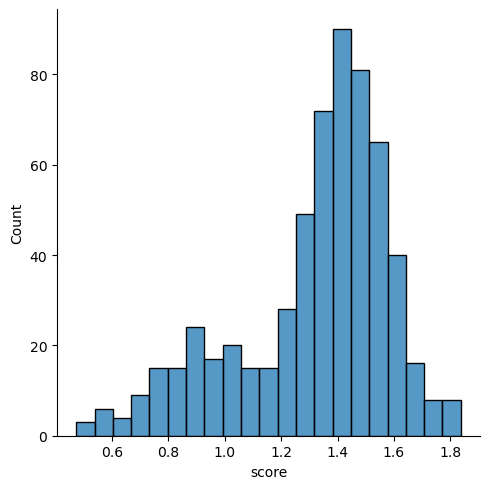

In [76]:
sns.displot(x="score",data=combo_df);

### Run Random Selections to Compare With Active Learning
Is active learning really better?  Let's select 600 random molecules and compare with the 600 selected using active learning. 

In [65]:
random_df = df.sample(600).copy()
random_shape_res = oracle.get_values(random_df.SMILES.values)
random_df = compile_results(random_df, random_shape_res)

  0%|          | 0/600 [00:00<?, ?it/s]

2023-12-03 16:06:50.887 | ERROR    | gen_conformers:generate_conformers:70 - Failed to generate 3D confs for C[C@@H]1C(=O)O[C@@H]2C[C@]34[C@H]5C[C@@H](C(C)(C)C)[C@@]36[C@@H](OC(=O)[C@@H]6O)O[C@@]4(C(=O)O5)[C@@]12O
2023-12-03 16:08:37.171 | ERROR    | gen_conformers:generate_conformers:70 - Failed to generate 3D confs for C[C@H](O/N=C1/[C@H]2O[C@@H]2[C@@H](O)[C@H]2[C@H]1CCn1c(=O)n(-c3ccccc3)c(=O)n12)c1cn([C@H]2COC[C@H]2O)nn1
2023-12-03 16:09:04.958 | ERROR    | gen_conformers:generate_conformers:70 - Failed to generate 3D confs for C[C@]12[NH2+][C@@H](Cc3ccccc31)c1ccccc12


View the score distribution for the random selection

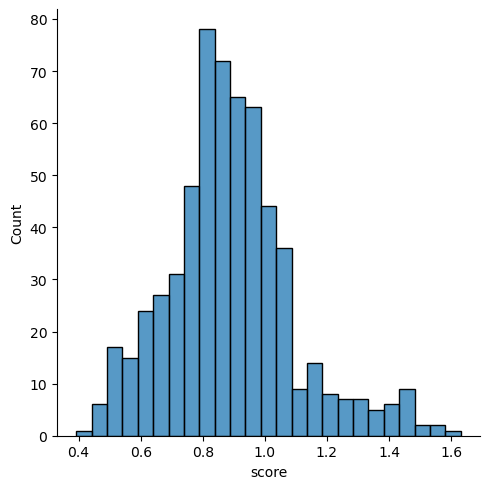

In [77]:
sns.displot(x="score",data=random_df);

Compare the scores for random selections with active learning. 

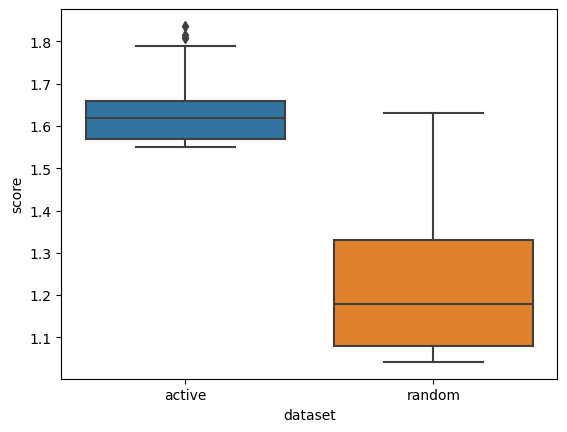

In [78]:
active_top_100_df = combo_df.sort_values("score",ascending=False).head(100)
active_top_100_df['dataset'] = "active"
random_top_100_df = random_df.sort_values("score",ascending=False).head(100)
random_top_100_df['dataset'] = "random"
plot_df = pd.concat([active_top_100_df, random_top_100_df])
sns.boxplot(x="dataset",y="score",data=plot_df);

Plot the scores of the molecules selected in each active learning round.  Remember that the first active learning cycle was randomly selected. 

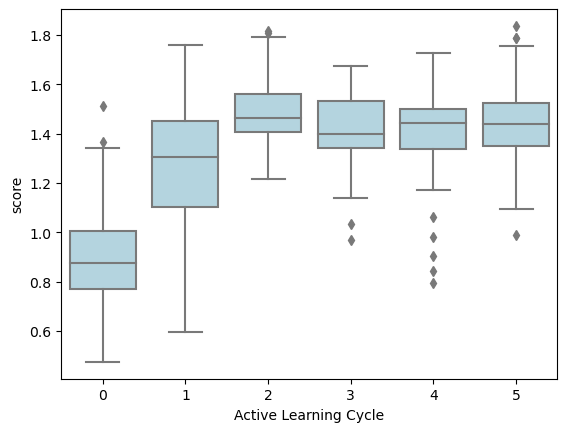

In [79]:
ax = sns.boxplot(x="cycle", y="score", data=combo_df,color="lightblue")
ax.set_xlabel("Active Learning Cycle");

Let's look at the highest scoring overlay and make sure our results make sense. We'll use [Py3DMol](https://pypi.org/project/py3Dmol/) to do this.

In [80]:
# read the the query molecule
query_mol = Chem.MolFromMolFile("data/2chw_lig.sdf")
# get the highest scoring molecule from combo_df
db_mol = combo_df.sort_values("score",ascending=False).shape_res.values[0].best_mol
db_mol = Chem.RemoveHs(db_mol)
# For Py3DMol, we need to convert molecules to molblocks
query_mblock = Chem.MolToMolBlock(query_mol)
db_mblock = Chem.MolToMolBlock(db_mol)
# create a Py3DMol view
view = py3Dmol.view()
# add the molecules
view.addModel(query_mblock, 'mol')
view.addModel(db_mblock, 'mol')
# color the molecules
view.setStyle({'model': 0},{'stick':{'colorscheme':'greenCarbon'}})
view.setStyle({'model': 1},{'stick':{'colorscheme':'lightgreyCarbon'}})
# Zoom in and show the molecules
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol